# MIMIC-IV Stay-Level EDA

This notebook performs exploratory data analysis on MIMIC-IV 3.1 at the **ICU stay** granularity.

## Goals
- Count unique patients and ICU stays
- Capture key clinical outcomes as boolean flags per stay:
  - **Death** (in-hospital and in-ICU)
  - **Sepsis** (Sepsis-3 criteria)
  - **Mechanical ventilation**
  - **CRRT** (Continuous Renal Replacement Therapy / kidney failure)
- Cache results locally to avoid repeat BigQuery costs

## Data Source
- BigQuery: `physionet-data.mimiciv_3_1_*` tables
- Primary table: `mimiciv_3_1_derived.icustay_detail` (~94k ICU stays)

## 1. Setup

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.cloud import bigquery

# Configuration
PROJECT_ID = "icu-project-486401"  # Update with your GCP project ID
DATA_DIR = Path("../data")
CACHE_FILE = DATA_DIR / "stay_summary.parquet"

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Ensure data directory exists
DATA_DIR.mkdir(exist_ok=True)

print(f"Cache file: {CACHE_FILE}")
print(f"Cache exists: {CACHE_FILE.exists()}")

Cache file: ../data/stay_summary.parquet
Cache exists: True


## 2. Data Retrieval

Single consolidated query to get stay-level summary with outcome flags.
Uses caching to avoid repeat BigQuery costs.

In [35]:
# Stay-level summary query with outcome flags
STAY_SUMMARY_QUERY = """
SELECT 
    i.subject_id,
    i.hadm_id,
    i.stay_id,
    i.gender,
    i.admission_age,
    i.race,
    i.los_icu,
    i.los_hospital,
    i.icu_intime,
    i.icu_outtime,
    i.hospstay_seq,
    i.icustay_seq,
    
    -- Death outcomes
    i.hospital_expire_flag,
    CASE WHEN a.deathtime BETWEEN i.icu_intime AND i.icu_outtime THEN 1 ELSE 0 END AS death_in_icu,
    
    -- Sepsis (Sepsis-3 criteria)
    CASE WHEN s.stay_id IS NOT NULL THEN 1 ELSE 0 END AS sepsis,
    
    -- Invasive ventilation (InvasiveVent + Tracheostomy) — comparable to eICU
    CASE WHEN v_inv.stay_id IS NOT NULL THEN 1 ELSE 0 END AS invasive_vent,
    
    -- Non-invasive respiratory support (SupplementalOxygen, NonInvasiveVent, HFNC)
    CASE WHEN v_noninv.stay_id IS NOT NULL THEN 1 ELSE 0 END AS noninvasive_vent,
    
    -- Any ventilation (all types)
    CASE WHEN v_any.stay_id IS NOT NULL THEN 1 ELSE 0 END AS ventilation,
    
    -- CRRT (Continuous Renal Replacement Therapy - indicates acute kidney injury)
    CASE WHEN cr.stay_id IS NOT NULL THEN 1 ELSE 0 END AS crrt

FROM `physionet-data.mimiciv_3_1_derived.icustay_detail` i
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` a 
    ON i.hadm_id = a.hadm_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.sepsis3`
) s ON i.stay_id = s.stay_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.ventilation`
    WHERE ventilation_status IN ('InvasiveVent', 'Tracheostomy')
) v_inv ON i.stay_id = v_inv.stay_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.ventilation`
    WHERE ventilation_status IN ('SupplementalOxygen', 'NonInvasiveVent', 'HFNC')
) v_noninv ON i.stay_id = v_noninv.stay_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.ventilation`
) v_any ON i.stay_id = v_any.stay_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.crrt`
) cr ON i.stay_id = cr.stay_id

ORDER BY i.subject_id, i.stay_id
"""

def load_stay_summary(force_refresh=False):
    """Load stay summary from cache or BigQuery."""
    if CACHE_FILE.exists() and not force_refresh:
        print(f"Loading from cache: {CACHE_FILE}")
        df = pd.read_parquet(CACHE_FILE)
        print(f"Loaded {len(df):,} rows from cache")
        return df
    
    print("Querying BigQuery (this may take a moment)...")
    client = bigquery.Client(project=PROJECT_ID)
    df = client.query(STAY_SUMMARY_QUERY).to_dataframe()
    
    # Save to cache
    df.to_parquet(CACHE_FILE, index=False)
    print(f"Saved {len(df):,} rows to {CACHE_FILE}")
    
    return df

In [36]:
# Load the data (from cache if available, otherwise query BigQuery)
df = load_stay_summary(force_refresh=False)
df.head()

Loading from cache: ../data/stay_summary.parquet
Loaded 94,458 rows from cache


,subject_id,hadm_id,stay_id,gender,admission_age,race,los_icu,los_hospital,icu_intime,icu_outtime,hospstay_seq,icustay_seq,hospital_expire_flag,death_in_icu,sepsis,invasive_vent,noninvasive_vent,ventilation,crrt
0,10000032,29079034,39553978,F,52,WHITE,0.380000000,2,2180-07-23 14:00:00,2180-07-23 23:50:47,1,1,0,0,0,0,1,1,0
1,10000690,25860671,37081114,F,86,WHITE,3.920000000,10,2150-11-02 19:37:00,2150-11-06 17:03:17,1,1,0,0,0,0,1,1,0
2,10000980,26913865,39765666,F,76,BLACK/AFRICAN AMERICAN,0.500000000,6,2189-06-27 08:42:00,2189-06-27 20:38:27,1,1,0,0,0,0,0,0,0
3,10001217,27703517,34592300,F,55,WHITE,0.960000000,6,2157-12-19 15:42:24,2157-12-20 14:27:41,2,1,0,0,0,0,0,0,0
4,10001217,24597018,37067082,F,55,WHITE,1.130000000,7,2157-11-20 19:18:02,2157-11-21 22:08:00,1,1,0,0,0,0,1,1,0


## 3. Basic Counts

In [37]:
n_stays = len(df)
n_patients = df['subject_id'].nunique()
n_admissions = df['hadm_id'].nunique()

print("=" * 50)
print("MIMIC-IV 3.1 Summary Statistics")
print("=" * 50)
print(f"Total ICU stays:        {n_stays:,}")
print(f"Unique patients:        {n_patients:,}")
print(f"Hospital admissions:    {n_admissions:,}")
print(f"Avg stays per patient:  {n_stays / n_patients:.2f}")
print("=" * 50)

MIMIC-IV 3.1 Summary Statistics
Total ICU stays:        94,458
Unique patients:        65,366
Hospital admissions:    85,242
Avg stays per patient:  1.45


In [38]:
# Distribution of ICU stays per patient
stays_per_patient = df.groupby('subject_id').size()
print("ICU stays per patient distribution:")
print(stays_per_patient.describe())

# How many patients have multiple ICU stays?
multi_stay_patients = (stays_per_patient > 1).sum()
print(f"\nPatients with multiple ICU stays: {multi_stay_patients:,} ({100*multi_stay_patients/n_patients:.1f}%)")

ICU stays per patient distribution:
count    65366.000000
mean         1.445063
std          1.169909
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

Patients with multiple ICU stays: 16,242 (24.8%)


## 4. Outcome Prevalence

Key clinical outcomes at the ICU stay level.

In [39]:
# Calculate outcome rates
outcomes = {
    'Hospital Death': df['hospital_expire_flag'].sum(),
    'ICU Death': df['death_in_icu'].sum(),
    'Sepsis (Sepsis-3)': df['sepsis'].sum(),
    'Invasive Vent': df['invasive_vent'].sum(),
    'Non-Invasive Resp Support': df['noninvasive_vent'].sum(),
    'Any Ventilation': df['ventilation'].sum(),
    'CRRT (Kidney Failure)': df['crrt'].sum()
}

print("=" * 60)
print("Outcome Prevalence (per ICU stay)")
print("=" * 60)
for outcome, count in outcomes.items():
    pct = 100 * count / n_stays
    print(f"{outcome:30s}: {count:>7,} stays ({pct:5.1f}%)")
print("=" * 60)
print("\nNote: Invasive Vent = InvasiveVent + Tracheostomy")
print("      Non-Invasive  = SupplementalOxygen + NonInvasiveVent + HFNC")

Outcome Prevalence (per ICU stay)
Hospital Death                :  11,350 stays ( 12.0%)
ICU Death                     :   7,329 stays (  7.8%)
Sepsis (Sepsis-3)             :  32,899 stays ( 34.8%)
Invasive Vent                 :  34,835 stays ( 36.9%)
Non-Invasive Resp Support     :  61,078 stays ( 64.7%)
Any Ventilation               :  70,783 stays ( 74.9%)
CRRT (Kidney Failure)         :   3,597 stays (  3.8%)

Note: Invasive Vent = InvasiveVent + Tracheostomy
      Non-Invasive  = SupplementalOxygen + NonInvasiveVent + HFNC


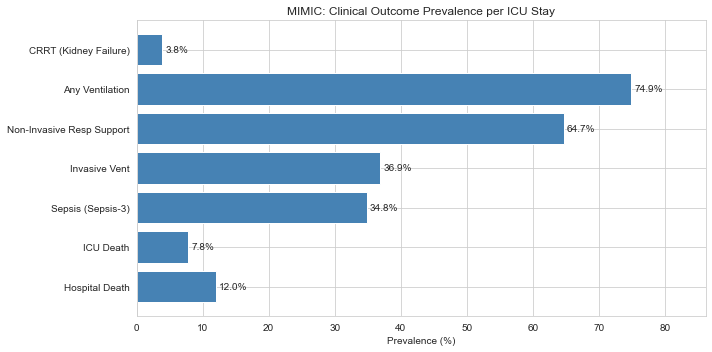

In [40]:
# Visualize outcome rates
outcome_rates = {k: 100 * v / n_stays for k, v in outcomes.items()}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(list(outcome_rates.keys()), list(outcome_rates.values()), color='steelblue')
ax.set_xlabel('Prevalence (%)')
ax.set_title('MIMIC: Clinical Outcome Prevalence per ICU Stay')

# Add value labels
for bar, pct in zip(bars, outcome_rates.values()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=10)

ax.set_xlim(0, max(outcome_rates.values()) * 1.15)
plt.tight_layout()
plt.show()

## 4b. MIMIC Invasive Ventilation by ICU Stay Year

  Year    Stays  Invasive    Rate  Any Vent    Rate
-------------------------------------------------------
  2110      619       268   43.3%       475   76.7%
  2111      741       276   37.2%       559   75.4%
  2112      842       305   36.2%       610   72.4%
  2113      802       332   41.4%       632   78.8%
  2114      864       333   38.5%       665   77.0%
  2115      888       347   39.1%       663   74.7%
  2116      876       329   37.6%       648   74.0%
  2117      918       342   37.3%       694   75.6%
  2118      914       354   38.7%       702   76.8%
  2119    1,023       367   35.9%       763   74.6%
  2120      940       349   37.1%       687   73.1%
  2121    1,032       394   38.2%       767   74.3%
  2122      987       355   36.0%       729   73.9%
  2123    1,045       417   39.9%       799   76.5%
  2124    1,089       413   37.9%       818   75.1%
  2125    1,101       424   38.5%       835   75.8%
  2126    1,086       437   40.2%       817   75.2%
  2127  

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

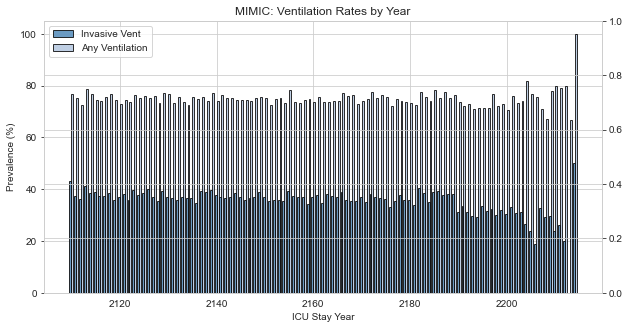

In [41]:
# Invasive ventilation rate by ICU stay year
df['icu_year'] = pd.to_datetime(df['icu_intime']).dt.year

yearly = df.groupby('icu_year').agg(
    n_stays=('stay_id', 'count'),
    n_invasive_vent=('invasive_vent', 'sum'),
    n_any_vent=('ventilation', 'sum'),
).reset_index()
yearly['invasive_vent_pct'] = 100 * yearly['n_invasive_vent'] / yearly['n_stays']
yearly['any_vent_pct'] = 100 * yearly['n_any_vent'] / yearly['n_stays']

# Print table
print(f"{'Year':>6s}  {'Stays':>7s}  {'Invasive':>8s}  {'Rate':>6s}  {'Any Vent':>8s}  {'Rate':>6s}")
print("-" * 55)
for _, row in yearly.iterrows():
    print(f"{int(row['icu_year']):>6d}  {int(row['n_stays']):>7,}  "
          f"{int(row['n_invasive_vent']):>8,}  {row['invasive_vent_pct']:>5.1f}%  "
          f"{int(row['n_any_vent']):>8,}  {row['any_vent_pct']:>5.1f}%")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(yearly['icu_year'] - 0.2, yearly['invasive_vent_pct'], width=0.4,
        color='steelblue', label='Invasive Vent', edgecolor='black', alpha=0.8)
ax1.bar(yearly['icu_year'] + 0.2, yearly['any_vent_pct'], width=0.4,
        color='lightsteelblue', label='Any Ventilation', edgecolor='black', alpha=0.8)
ax1.set_xlabel('ICU Stay Year')
ax1.set_ylabel('Prevalence (%)')
ax1.set_title('MIMIC: Ventilation Rates by Year')
ax1.legend(loc='upper left')

# Overlay stay count on secondary axis
ax2 = ax1.twinx()
ax2.plot(yearly['icu_year'], yearly['n_stays'], 'o--', color='gray', alpha=0.6, label='# Stays')
ax2.set_ylabel('Number of ICU Stays', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 5. Demographics

In [ ]:
# Age distribution
print("Age at admission:")
print(df['admission_age'].describe())

# Gender distribution
print("\nGender distribution:")
print(df['gender'].value_counts())

In [ ]:
# Visualize demographics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Age distribution
axes[0].hist(df['admission_age'], bins=30, edgecolor='white', color='steelblue')
axes[0].set_xlabel('Age at Admission')
axes[0].set_ylabel('Number of ICU Stays')
axes[0].set_title('Age Distribution')
axes[0].axvline(df['admission_age'].median(), color='red', linestyle='--', label=f"Median: {df['admission_age'].median():.0f}")
axes[0].legend()

# Gender distribution
gender_counts = df['gender'].value_counts()
axes[1].bar(gender_counts.index, gender_counts.values, color=['steelblue', 'coral'])
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Number of ICU Stays')
axes[1].set_title('Gender Distribution')
for i, (g, c) in enumerate(gender_counts.items()):
    axes[1].text(i, c + 500, f'{100*c/n_stays:.1f}%', ha='center')

# ICU Length of Stay distribution (capped at 30 days for visualization)
los_capped = df['los_icu'].clip(upper=30)
axes[2].hist(los_capped, bins=30, edgecolor='white', color='steelblue')
axes[2].set_xlabel('ICU Length of Stay (days)')
axes[2].set_ylabel('Number of ICU Stays')
axes[2].set_title('ICU LOS Distribution (capped at 30d)')
axes[2].axvline(df['los_icu'].median(), color='red', linestyle='--', label=f"Median: {df['los_icu'].median():.1f}d")
axes[2].legend()

plt.tight_layout()
plt.show()

Race/Ethnicity distribution:
race
WHITE                                        58888
BLACK/AFRICAN AMERICAN                        8677
UNKNOWN                                       8457
OTHER                                         3134
WHITE - OTHER EUROPEAN                        2310
UNABLE TO OBTAIN                              1881
HISPANIC/LATINO - PUERTO RICAN                1214
ASIAN                                         1095
ASIAN - CHINESE                               1062
WHITE - RUSSIAN                                980
HISPANIC OR LATINO                             783
HISPANIC/LATINO - DOMINICAN                    746
BLACK/CAPE VERDEAN                             656
BLACK/CARIBBEAN ISLAND                         621
PATIENT DECLINED TO ANSWER                     515
BLACK/AFRICAN                                  431
PORTUGUESE                                     425
ASIAN - SOUTH EAST ASIAN                       408
WHITE - EASTERN EUROPEAN                       2

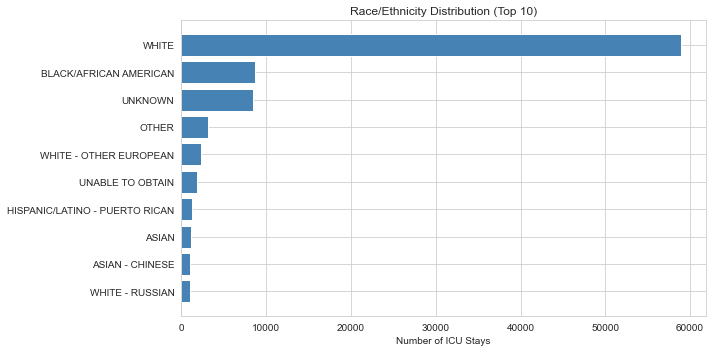

In [42]:
# Race/ethnicity distribution
print("Race/Ethnicity distribution:")
race_counts = df['race'].value_counts()
print(race_counts)

# Visualize top races
fig, ax = plt.subplots(figsize=(10, 5))
top_races = race_counts.head(10)
bars = ax.barh(top_races.index[::-1], top_races.values[::-1], color='steelblue')
ax.set_xlabel('Number of ICU Stays')
ax.set_title('Race/Ethnicity Distribution (Top 10)')
plt.tight_layout()
plt.show()

## 6. Data Summary

Overview of the cached dataset schema and storage.

In [43]:
# Data schema
print("Dataset Schema:")
print("-" * 60)
df.info()

# File size
if CACHE_FILE.exists():
    size_mb = CACHE_FILE.stat().st_size / (1024 * 1024)
    print(f"\nCache file size: {size_mb:.2f} MB")

Dataset Schema:
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94458 entries, 0 to 94457
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            94458 non-null  Int64         
 1   hadm_id               94458 non-null  Int64         
 2   stay_id               94458 non-null  Int64         
 3   gender                94458 non-null  object        
 4   admission_age         94458 non-null  Int64         
 5   race                  94458 non-null  object        
 6   los_icu               94444 non-null  object        
 7   los_hospital          94458 non-null  Int64         
 8   icu_intime            94458 non-null  datetime64[us]
 9   icu_outtime           94444 non-null  datetime64[us]
 10  hospstay_seq          94458 non-null  Int64         
 11  icustay_seq           94458 non-null  Int64         
 1

## 7. Outcome Co-occurrence

How often do these clinical outcomes occur together?

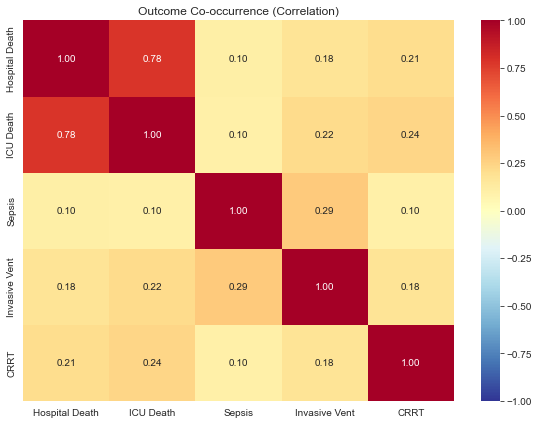

In [44]:
# Outcome co-occurrence matrix
outcome_cols = ['hospital_expire_flag', 'death_in_icu', 'sepsis', 'invasive_vent', 'crrt']
outcome_names = ['Hospital Death', 'ICU Death', 'Sepsis', 'Invasive Vent', 'CRRT']

# Calculate correlation matrix for binary outcomes
corr_matrix = df[outcome_cols].corr()
corr_matrix.index = outcome_names
corr_matrix.columns = outcome_names

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, vmin=-1, vmax=1, ax=ax)
ax.set_title('Outcome Co-occurrence (Correlation)')
plt.tight_layout()
plt.show()

In [45]:
# Count stays by number of adverse outcomes
# (excluding hospital death since ICU death is a subset)
adverse_outcomes = ['death_in_icu', 'sepsis', 'invasive_vent', 'crrt']
df['n_adverse_outcomes'] = df[adverse_outcomes].sum(axis=1)

print("Distribution of adverse outcomes per stay:")
outcome_dist = df['n_adverse_outcomes'].value_counts().sort_index()
for n, count in outcome_dist.items():
    print(f"  {n} outcomes: {count:>6,} stays ({100*count/n_stays:5.1f}%)")

# Stays with at least one adverse outcome
any_adverse = (df['n_adverse_outcomes'] > 0).sum()
print(f"\nStays with >= 1 adverse outcome: {any_adverse:,} ({100*any_adverse/n_stays:.1f}%)")

Distribution of adverse outcomes per stay:
  0 outcomes: 43,481 stays ( 46.0%)
  1 outcomes: 28,661 stays ( 30.3%)
  2 outcomes: 17,722 stays ( 18.8%)
  3 outcomes:  3,821 stays (  4.0%)
  4 outcomes:    773 stays (  0.8%)

Stays with >= 1 adverse outcome: 50,977 (54.0%)


# eICU Stay-Level EDA

This section mirrors the MIMIC analysis above using eICU Collaborative Research Database data from BigQuery (`physionet-data.eicu_crd.*`).

## Key Differences from MIMIC
- **Patient ID**: eICU uses `patientunitstayid` (one per ICU stay)
- **Time**: offsets in minutes from ICU admission, not absolute timestamps
- **Race/Ethnicity**: column is `ethnicity` (not `race`)
- **Sepsis-3**: no derived table; uses pre-computed CSV
- **LOS**: computed from `unitdischargeoffset` (minutes)

## 8. eICU Data Retrieval

In [46]:
EICU_CACHE_FILE = DATA_DIR / "eicu_stay_summary.parquet"

EICU_STAY_SUMMARY_QUERY = """
SELECT
    p.patientunitstayid,
    p.gender,
    p.age,
    p.ethnicity,
    ROUND(p.unitdischargeoffset / 60.0, 2) AS icu_los_hours,
    p.hospitaldischargeyear,
    p.hospitalid,
    p.hospitaladmitsource,

    -- Hospital mortality
    CASE WHEN LOWER(p.hospitaldischargestatus) LIKE '%expired%' THEN 1
         WHEN LOWER(p.hospitaldischargestatus) LIKE '%alive%' THEN 0
         ELSE NULL END AS hospital_expire_flag,

    -- ICU mortality
    CASE WHEN LOWER(p.unitdischargestatus) LIKE '%expired%' THEN 1
         WHEN LOWER(p.unitdischargestatus) LIKE '%alive%' THEN 0
         ELSE NULL END AS death_in_icu,

    -- Mechanical ventilation (had any prior vent episode)
    CASE WHEN vent.patientunitstayid IS NOT NULL THEN 1 ELSE 0 END AS ventilation,

    -- CRRT (had any CRRT intake/output)
    CASE WHEN crrt.patientunitstayid IS NOT NULL THEN 1 ELSE 0 END AS crrt

FROM `physionet-data.eicu_crd.patient` p

LEFT JOIN (
    SELECT DISTINCT patientunitstayid
    FROM `physionet-data.eicu_crd.respiratorycare`
    WHERE priorventstartoffset > 0 OR priorventendoffset > 0
) vent ON p.patientunitstayid = vent.patientunitstayid

LEFT JOIN (
    SELECT DISTINCT patientunitstayid
    FROM `physionet-data.eicu_crd.intakeoutput`
    WHERE LOWER(cellpath) LIKE '%crrt%'
) crrt ON p.patientunitstayid = crrt.patientunitstayid

ORDER BY p.patientunitstayid
"""

def load_eicu_stay_summary(force_refresh=False):
    """Load eICU stay summary from cache or BigQuery."""
    if EICU_CACHE_FILE.exists() and not force_refresh:
        print(f"Loading from cache: {EICU_CACHE_FILE}")
        edf = pd.read_parquet(EICU_CACHE_FILE)
        print(f"Loaded {len(edf):,} rows from cache")
        return edf

    print("Querying BigQuery for eICU data (this may take a moment)...")
    client = bigquery.Client(project=PROJECT_ID)
    edf = client.query(EICU_STAY_SUMMARY_QUERY).to_dataframe()

    edf.to_parquet(EICU_CACHE_FILE, index=False)
    print(f"Saved {len(edf):,} rows to {EICU_CACHE_FILE}")
    return edf

In [47]:
edf = load_eicu_stay_summary(force_refresh=False)

# Normalize gender to M/F to align with MIMIC
edf['gender'] = edf['gender'].map({'Male': 'M', 'Female': 'F'}).fillna('Other')

edf.head()

Loading from cache: ../data/eicu_stay_summary.parquet
Loaded 200,859 rows from cache


,patientunitstayid,gender,age,ethnicity,icu_los_hours,hospitaldischargeyear,hospitalid,hospitaladmitsource,hospital_expire_flag,death_in_icu,ventilation,crrt
0,141168,F,70,Caucasian,59.93,2015,59,Direct Admit,1,1,0,0
1,141178,F,52,Caucasian,0.13,2015,60,Emergency Department,0,0,0,0
2,141179,F,52,Caucasian,34.03,2015,60,Emergency Department,0,0,0,0
3,141194,M,68,Caucasian,80.22,2015,73,Floor,0,0,0,0
4,141196,M,71,Caucasian,24.38,2015,67,Emergency Department,0,0,0,0


In [48]:
edf['ethnicity'].value_counts(normalize=True)

ethnicity
Caucasian           0.773105
African American    0.106084
Other/Unknown       0.047506
Hispanic            0.037160
Asian               0.016280
                    0.011401
Native American     0.008464
Name: proportion, dtype: float64

In [49]:
edf[edf['ethnicity']==""]

,patientunitstayid,gender,age,ethnicity,icu_los_hours,hospitaldischargeyear,hospitalid,hospitaladmitsource,hospital_expire_flag,death_in_icu,ventilation,crrt
27,141329,M,50,,42.87,2015,73,Direct Admit,0,0,0,0
40,141451,M,39,,64.72,2015,73,Operating Room,0,0,1,0
67,141651,F,71,,15.70,2014,73,Emergency Department,0,0,0,0
381,143799,M,54,,0.88,2015,71,Direct Admit,0,0,0,0
382,143800,M,54,,14.78,2015,71,Direct Admit,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
197679,3333667,M,> 89,,0.12,2015,458,Emergency Department,1,1,0,0
197714,3333921,F,71,,29.43,2015,458,Direct Admit,0,0,0,0
197831,3334616,M,60,,29.03,2015,458,Direct Admit,0,0,0,0
198353,3337852,M,73,,28.42,2015,458,,0,0,0,0


In [50]:
edf[edf['patientunitstayid']==1658279]

,patientunitstayid,gender,age,ethnicity,icu_los_hours,hospitaldischargeyear,hospitalid,hospitaladmitsource,hospital_expire_flag,death_in_icu,ventilation,crrt
107137,1658279,Other,36,,8.62,2015,267,Emergency Department,0,0,0,0


## 9. eICU Basic Counts

In [51]:
e_n_stays = len(edf)
e_n_hospitals = edf['hospitalid'].nunique()

print("=" * 50)
print("eICU Summary Statistics")
print("=" * 50)
print(f"Total ICU stays:        {e_n_stays:,}")
print(f"Unique hospitals:       {e_n_hospitals:,}")
print("=" * 50)

# Note: eICU does not have a subject_id equivalent for cross-stay patient tracking
# patientunitstayid is unique per ICU stay

eICU Summary Statistics
Total ICU stays:        200,859
Unique hospitals:       208


## 10. eICU Outcome Prevalence

eICU Outcome Prevalence (per ICU stay)
Hospital Death                :  18,004 stays (  9.0%)
ICU Death                     :  10,907 stays (  5.4%)
Invasive Vent                 :  26,406 stays ( 13.1%)
CRRT (Kidney Failure)         :     189 stays (  0.1%)

Note: eICU vent from respiratorycare (invasive only; no non-invasive equivalent)


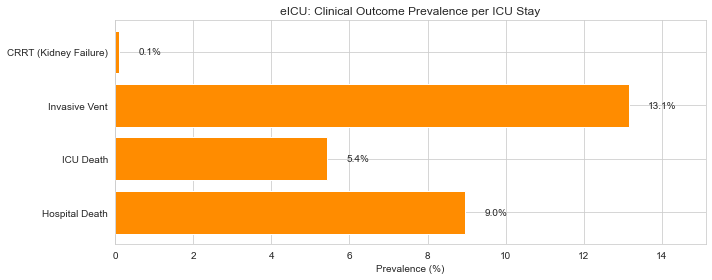

In [52]:
# eICU outcome rates
# Note: eICU ventilation from respiratorycare = invasive vent only
e_outcomes = {
    'Hospital Death': edf['hospital_expire_flag'].sum(),
    'ICU Death': edf['death_in_icu'].sum(),
    'Invasive Vent': edf['ventilation'].sum(),
    'CRRT (Kidney Failure)': edf['crrt'].sum(),
}

print("=" * 60)
print("eICU Outcome Prevalence (per ICU stay)")
print("=" * 60)
for outcome, count in e_outcomes.items():
    pct = 100 * count / e_n_stays
    print(f"{outcome:30s}: {count:>7,.0f} stays ({pct:5.1f}%)")
print("=" * 60)
print("\nNote: eICU vent from respiratorycare (invasive only; no non-invasive equivalent)")

# Visualize
e_outcome_rates = {k: 100 * v / e_n_stays for k, v in e_outcomes.items()}

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.barh(list(e_outcome_rates.keys()), list(e_outcome_rates.values()), color='darkorange')
ax.set_xlabel('Prevalence (%)')
ax.set_title('eICU: Clinical Outcome Prevalence per ICU Stay')
for bar, pct in zip(bars, e_outcome_rates.values()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', va='center', fontsize=10)
ax.set_xlim(0, max(e_outcome_rates.values()) * 1.15)
plt.tight_layout()
plt.show()

## 11. eICU Demographics

eICU Age at admission (ages > 89 mapped to 90):
count    200764.000000
mean         63.079456
std          17.178207
min           0.000000
25%          53.000000
50%          65.000000
75%          76.000000
max          90.000000
Name: age_numeric, dtype: float64

Patients with original age '> 89' (mapped to 90): 7,081

eICU Gender distribution:
gender
M        108379
F         92303
Other       177
Name: count, dtype: int64

eICU Ethnicity distribution:
ethnicity
Caucasian           155285
African American     21308
Other/Unknown         9542
Hispanic              7464
Asian                 3270
                      2290
Native American       1700
Name: count, dtype: int64


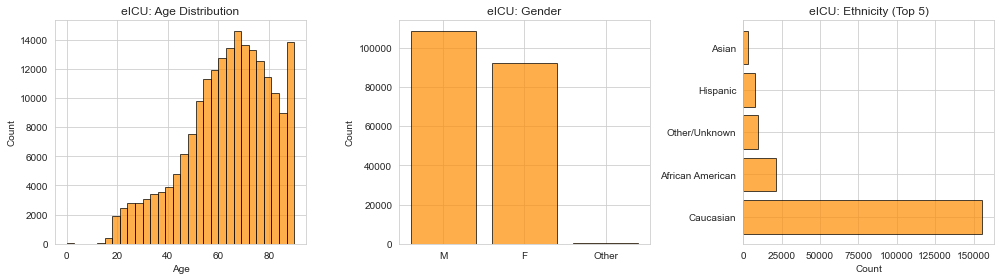

In [53]:
# eICU age — note: eICU encodes ages > 89 as "> 89" (string)
# Map "> 89" to 90 so these patients are included in distributions
edf['age_numeric'] = pd.to_numeric(edf['age'].replace('> 89', '90'), errors='coerce')

print("eICU Age at admission (ages > 89 mapped to 90):")
print(edf['age_numeric'].describe())
print(f"\nPatients with original age '> 89' (mapped to 90): {edf['age'].eq('> 89').sum():,}")

# Gender distribution
print("\neICU Gender distribution:")
print(edf['gender'].value_counts())

# Ethnicity distribution
print("\neICU Ethnicity distribution:")
eth_counts = edf['ethnicity'].value_counts()
print(eth_counts.head(10))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Age
axes[0].hist(edf['age_numeric'].dropna(), bins=30, color='darkorange', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('eICU: Age Distribution')

# Gender
gender_counts = edf['gender'].value_counts()
axes[1].bar(gender_counts.index, gender_counts.values, color='darkorange', edgecolor='black', alpha=0.7)
axes[1].set_title('eICU: Gender')
axes[1].set_ylabel('Count')

# Ethnicity (top 5)
top_eth = eth_counts.head(5)
axes[2].barh(top_eth.index, top_eth.values, color='darkorange', edgecolor='black', alpha=0.7)
axes[2].set_title('eICU: Ethnicity (Top 5)')
axes[2].set_xlabel('Count')

plt.tight_layout()
plt.show()

---

# Cross-Source Comparison: MIMIC vs eICU

Side-by-side comparison of key distributions between the two data sources.

**Important caveats:**
- MIMIC is single-center (Beth Israel Deaconess, Boston); eICU is multi-center (200+ hospitals across the US)
- Race/ethnicity coding differs between sources
- eICU caps age at "> 89"; MIMIC reports exact ages
- Sepsis-3 not available in the eICU query above (would need the CSV join)

## 12. Outcome Rate Comparison

In [54]:
df.head()

,subject_id,hadm_id,stay_id,gender,admission_age,race,los_icu,los_hospital,icu_intime,icu_outtime,...,icustay_seq,hospital_expire_flag,death_in_icu,sepsis,invasive_vent,noninvasive_vent,ventilation,crrt,icu_year,n_adverse_outcomes
0,10000032,29079034,39553978,F,52,WHITE,0.380000000,2,2180-07-23 14:00:00,2180-07-23 23:50:47,...,1,0,0,0,0,1,1,0,2180,0
1,10000690,25860671,37081114,F,86,WHITE,3.920000000,10,2150-11-02 19:37:00,2150-11-06 17:03:17,...,1,0,0,0,0,1,1,0,2150,0
2,10000980,26913865,39765666,F,76,BLACK/AFRICAN AMERICAN,0.500000000,6,2189-06-27 08:42:00,2189-06-27 20:38:27,...,1,0,0,0,0,0,0,0,2189,0
3,10001217,27703517,34592300,F,55,WHITE,0.960000000,6,2157-12-19 15:42:24,2157-12-20 14:27:41,...,1,0,0,0,0,0,0,0,2157,0
4,10001217,24597018,37067082,F,55,WHITE,1.130000000,7,2157-11-20 19:18:02,2157-11-21 22:08:00,...,1,0,0,0,0,1,1,0,2157,0


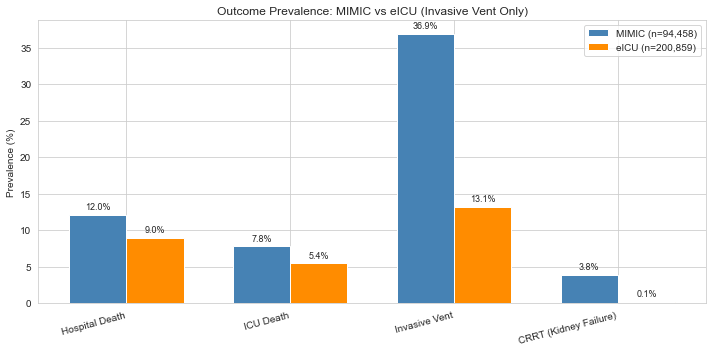

In [55]:
# Side-by-side outcome rates — using Invasive Vent for apples-to-apples comparison
shared_outcomes = ['Hospital Death', 'ICU Death', 'Invasive Vent', 'CRRT (Kidney Failure)']

mimic_rates = [100 * outcomes[k] / n_stays for k in shared_outcomes]
eicu_rates  = [100 * e_outcomes[k] / e_n_stays for k in shared_outcomes]

x = np.arange(len(shared_outcomes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, mimic_rates, width, label=f'MIMIC (n={n_stays:,})', color='steelblue')
bars2 = ax.bar(x + width/2, eicu_rates, width, label=f'eICU (n={e_n_stays:,})', color='darkorange')

ax.set_ylabel('Prevalence (%)')
ax.set_title('Outcome Prevalence: MIMIC vs eICU (Invasive Vent Only)')
ax.set_xticks(x)
ax.set_xticklabels(shared_outcomes, rotation=15, ha='right')
ax.legend()

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 13. Age Distribution Comparison

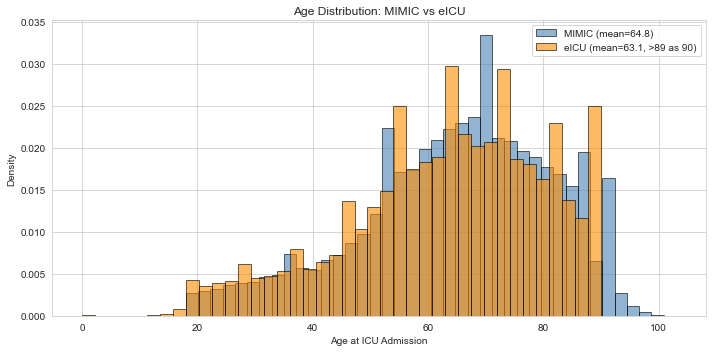

                                MIMIC        eICU
--------------------------------------------------
                 Mean age        64.8        63.1
               Median age        66.0        65.0
                  Std dev        16.7        17.2
                  Min age          18           0
                  Max age         103          90


In [56]:
# Overlaid age distributions
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df['admission_age'], bins=40, alpha=0.6, color='steelblue',
        label=f'MIMIC (mean={df["admission_age"].mean():.1f})', density=True, edgecolor='black')
ax.hist(edf['age_numeric'].dropna(), bins=40, alpha=0.6, color='darkorange',
        label=f'eICU (mean={edf["age_numeric"].mean():.1f}, >89 as 90)', density=True, edgecolor='black')

ax.set_xlabel('Age at ICU Admission')
ax.set_ylabel('Density')
ax.set_title('Age Distribution: MIMIC vs eICU')
ax.legend()
plt.tight_layout()
plt.show()

# Summary stats side by side
print(f"{'':>25s}  {'MIMIC':>10s}  {'eICU':>10s}")
print("-" * 50)
print(f"{'Mean age':>25s}  {df['admission_age'].mean():>10.1f}  {edf['age_numeric'].mean():>10.1f}")
print(f"{'Median age':>25s}  {df['admission_age'].median():>10.1f}  {edf['age_numeric'].median():>10.1f}")
print(f"{'Std dev':>25s}  {df['admission_age'].std():>10.1f}  {edf['age_numeric'].std():>10.1f}")
print(f"{'Min age':>25s}  {df['admission_age'].min():>10.0f}  {edf['age_numeric'].min():>10.0f}")
print(f"{'Max age':>25s}  {df['admission_age'].max():>10.0f}  {edf['age_numeric'].max():>10.0f}")

## 14. Gender Comparison

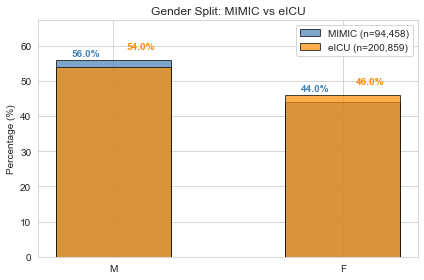

Note: 177 eICU stays with gender = '' / 'Unknown' / 'Other' grouped as 'Other' (0.09%)


In [57]:
# Gender comparison — overlapping bars (both normalized to M/F)
genders = ['M', 'F']
mimic_pct = [100 * (df['gender'] == g).mean() for g in genders]
eicu_pct  = [100 * (edf['gender'] == g).mean() for g in genders]

x = np.arange(len(genders))
width = 0.5

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x, mimic_pct, width, label=f'MIMIC (n={n_stays:,})', color='steelblue', alpha=0.7, edgecolor='black')
ax.bar(x, eicu_pct, width, label=f'eICU (n={e_n_stays:,})', color='darkorange', alpha=0.7, edgecolor='black')

# Value labels
for i, (mp, ep) in enumerate(zip(mimic_pct, eicu_pct)):
    ax.text(i - 0.12, max(mp, ep) + 1, f'{mp:.1f}%', ha='center', fontsize=10, color='steelblue', fontweight='bold')
    ax.text(i + 0.12, max(mp, ep) + 3, f'{ep:.1f}%', ha='center', fontsize=10, color='darkorange', fontweight='bold')

ax.set_ylabel('Percentage (%)')
ax.set_title('Gender Split: MIMIC vs eICU')
ax.set_xticks(x)
ax.set_xticklabels(genders)
ax.legend()
ax.set_ylim(0, max(max(mimic_pct), max(eicu_pct)) * 1.2)
plt.tight_layout()
plt.show()

# Note: eICU has a small number of Other/Unknown/blank gender values grouped as 'Other'
n_other = (edf['gender'] == 'Other').sum()
if n_other > 0:
    print(f"Note: {n_other} eICU stays with gender = '' / 'Unknown' / 'Other' grouped as 'Other' ({100*n_other/e_n_stays:.2f}%)")

## 15. Race/Ethnicity Comparison

Note: MIMIC uses `race` with categories like "WHITE", "BLACK/AFRICAN AMERICAN", etc. eICU uses `ethnicity` with categories like "Caucasian", "African American", etc. Direct comparison requires mapping.

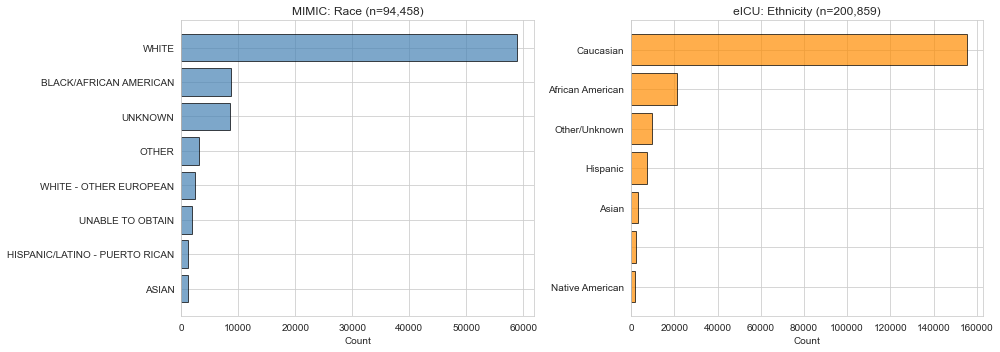

                         MIMIC Race       %                         eICU Ethnicity       %
------------------------------------------------------------------------------------------
                              WHITE   62.3%                              Caucasian   77.3%
             BLACK/AFRICAN AMERICAN    9.2%                       African American   10.6%
                            UNKNOWN    9.0%                          Other/Unknown    4.8%
                              OTHER    3.3%                               Hispanic    3.7%
             WHITE - OTHER EUROPEAN    2.4%                                  Asian    1.6%
                   UNABLE TO OBTAIN    2.0%                                           1.1%
     HISPANIC/LATINO - PUERTO RICAN    1.3%                        Native American    0.8%


In [58]:
# Race/Ethnicity — show top categories from each source side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MIMIC
mimic_race = df['race'].value_counts().head(8)
axes[0].barh(mimic_race.index[::-1], mimic_race.values[::-1], color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title(f'MIMIC: Race (n={n_stays:,})')
axes[0].set_xlabel('Count')

# eICU
eicu_eth = edf['ethnicity'].value_counts().head(8)
axes[1].barh(eicu_eth.index[::-1], eicu_eth.values[::-1], color='darkorange', edgecolor='black', alpha=0.7)
axes[1].set_title(f'eICU: Ethnicity (n={e_n_stays:,})')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

# Print percentages
print(f"{'MIMIC Race':>35s}  {'%':>6s}    {'eICU Ethnicity':>35s}  {'%':>6s}")
print("-" * 90)
mimic_race_pct = df['race'].value_counts(normalize=True).head(8) * 100
eicu_eth_pct = edf['ethnicity'].value_counts(normalize=True).head(8) * 100
for (mr, mp), (er, ep) in zip(mimic_race_pct.items(), eicu_eth_pct.items()):
    print(f"{mr:>35s}  {mp:>5.1f}%    {er:>35s}  {ep:>5.1f}%")

## 16. ICU Length of Stay Comparison

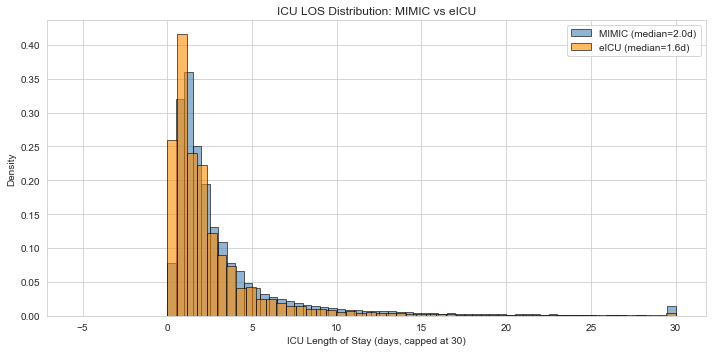

           ICU LOS (days)       MIMIC        eICU
--------------------------------------------------
                     Mean        3.63        2.68
                   Median        1.96        1.57
                  Std dev        5.40        4.33
                      Max       226.4       506.4


In [59]:
# LOS comparison (in days for readability)
mimic_los_days = df['los_icu'].astype(float)  # already in days
eicu_los_days = edf['icu_los_hours'] / 24.0   # convert hours to days

# Cap at 30 days for visualization
cap = 30

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(mimic_los_days.clip(upper=cap), bins=60, alpha=0.6, color='steelblue',
        label=f'MIMIC (median={mimic_los_days.median():.1f}d)', density=True, edgecolor='black')
ax.hist(eicu_los_days.clip(upper=cap), bins=60, alpha=0.6, color='darkorange',
        label=f'eICU (median={eicu_los_days.median():.1f}d)', density=True, edgecolor='black')
ax.set_xlabel('ICU Length of Stay (days, capped at 30)')
ax.set_ylabel('Density')
ax.set_title('ICU LOS Distribution: MIMIC vs eICU')
ax.legend()
plt.tight_layout()
plt.show()

# Summary stats
print(f"{'ICU LOS (days)':>25s}  {'MIMIC':>10s}  {'eICU':>10s}")
print("-" * 50)
print(f"{'Mean':>25s}  {mimic_los_days.mean():>10.2f}  {eicu_los_days.mean():>10.2f}")
print(f"{'Median':>25s}  {mimic_los_days.median():>10.2f}  {eicu_los_days.median():>10.2f}")
print(f"{'Std dev':>25s}  {mimic_los_days.std():>10.2f}  {eicu_los_days.std():>10.2f}")
print(f"{'Max':>25s}  {mimic_los_days.max():>10.1f}  {eicu_los_days.max():>10.1f}")

---

# Extracted Pipeline Output: MIMIC & eICU

The METRE extraction pipeline produces three table types per data source:

- **Vital** — Hourly time-series of clinical measurements for each ICU stay. Each row is one patient-hour. Every variable has two columns: `mean` (average value measured that hour) and `count` (number of measurements). Covers vitals (heart rate, blood pressure, SpO2, temperature, respiratory rate), labs (CBC, chemistry, coagulation, blood gas, liver enzymes), GCS, urine output, ventilator settings, weight, and culture results.

- **Intervention** — Hourly binary indicators of active treatments for each ICU stay. Each row is one patient-hour. 16 columns: mechanical ventilation, antibiotics, 7 vasoactive drugs (dopamine, epinephrine, norepinephrine, phenylephrine, vasopressin, dobutamine, milrinone), heparin, CRRT, 3 transfusion types (RBC, platelets, FFP), colloid bolus, and crystalloid bolus. Values are 0 or 1.

- **Static** — One row per ICU stay with time-invariant patient info. Demographics (age, gender, race/ethnicity), admission details (admit source, discharge location, LOS), outcomes (hospital mortality, ICU mortality), and Charlson comorbidity flags (17 binary indicators like diabetes, heart failure, renal disease, etc.).

In [ ]:
import pandas as pd
import numpy as np

OUTPUT_DIR = "../METRE/output"

mimic_vital = pd.read_parquet(f"{OUTPUT_DIR}/MEEP_MIMIC_vital.parquet")
mimic_inv = pd.read_parquet(f"{OUTPUT_DIR}/MEEP_MIMIC_inv.parquet")
mimic_static = pd.read_parquet(f"{OUTPUT_DIR}/MEEP_MIMIC_static.parquet")
eicu_vital = pd.read_parquet(f"{OUTPUT_DIR}/MEEP_eICU_vital.parquet")
eicu_inv = pd.read_parquet(f"{OUTPUT_DIR}/MEEP_eICU_inv.parquet")
eicu_static = pd.read_parquet(f"{OUTPUT_DIR}/MEEP_eICU_static.parquet")

tables = {
    "MIMIC vital": mimic_vital,
    "MIMIC inv": mimic_inv,
    "MIMIC static": mimic_static,
    "eICU vital": eicu_vital,
    "eICU inv": eicu_inv,
    "eICU static": eicu_static,
}

summary = []
for name, df in tables.items():
    n_stays = df.index.get_level_values(0).nunique()
    summary.append({"Table": name, "Rows": f"{df.shape[0]:,}", "Columns": df.shape[1], "Stays": f"{n_stays:,}"})

pd.DataFrame(summary).set_index("Table")

## Static Table Summary

In [ ]:
for label, sdf in [("MIMIC", mimic_static), ("eICU", eicu_static)]:
    print(f"\n{'='*80}")
    print(f"{label} STATIC  |  {sdf.shape[0]:,} stays x {sdf.shape[1]} cols")
    print(f"{'='*80}")

    num = sdf.select_dtypes(include=[np.number])
    desc = num.describe().T
    desc["missing%"] = (num.isnull().sum() / len(num) * 100).round(1)
    print(f"\n--- Numeric columns ({len(num.columns)}) ---")
    display(desc[["count", "mean", "std", "min", "25%", "50%", "75%", "max", "missing%"]])

    cats = sdf.select_dtypes(exclude=[np.number])
    if len(cats.columns) > 0:
        print(f"\n--- Categorical columns ({len(cats.columns)}) ---")
        cat_rows = []
        for c in cats.columns:
            n_unique = cats[c].nunique()
            missing = cats[c].isnull().sum()
            top = cats[c].value_counts().head(3)
            top_str = ", ".join([f"{v} ({k})" for k, v in top.items()])
            cat_rows.append({"column": c, "unique": n_unique, "missing": missing,
                             "missing%": round(missing / len(sdf) * 100, 1), "top_3": top_str})
        display(pd.DataFrame(cat_rows).set_index("column"))

## Intervention Table Summary

In [ ]:
for label, idf in [("MIMIC", mimic_inv), ("eICU", eicu_inv)]:
    n_stays = idf.index.get_level_values(0).nunique()
    print(f"\n{'='*80}")
    print(f"{label} INTERVENTION  |  {idf.shape[0]:,} patient-hours  |  {n_stays:,} stays  |  {idf.shape[1]} cols")
    print(f"{'='*80}")

    rows = []
    for c in idf.columns:
        pct_hours = (idf[c] > 0).sum() / len(idf) * 100
        stay_level = idf[c].groupby(level=0).max()
        pct_stays = (stay_level > 0).sum() / len(stay_level) * 100
        rows.append({"intervention": c, "hours_active%": round(pct_hours, 2),
                      "stays_with_any%": round(pct_stays, 2)})

    display(pd.DataFrame(rows).set_index("intervention"))

## Vital Table Summary

For each measurement variable: data availability (% of patient-hours with a non-null value), % of hours where a measurement was actually taken (count > 0), and summary statistics of the mean values.

In [ ]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

for label, vdf in [("MIMIC", mimic_vital), ("eICU", eicu_vital)]:
    n_stays = vdf.index.get_level_values(0).nunique()
    print(f"\n{'='*80}")
    print(f"{label} VITAL  |  {vdf.shape[0]:,} patient-hours  |  {n_stays:,} stays  |  {vdf.shape[1]} cols")
    print(f"{'='*80}")

    rows = []
    for c in vdf.columns:
        cs = str(c)
        if "count" in cs or "mask" in cs:
            continue

        series = vdf[c]
        available = series.notna().sum() / len(vdf) * 100

        count_col = None
        if isinstance(c, tuple) and len(c) == 2 and c[1] == "mean":
            count_col = (c[0], "count")
        if count_col and count_col in vdf.columns:
            measured = (vdf[count_col] > 0).sum() / len(vdf) * 100
        else:
            measured = available

        non_null = series.dropna()
        if len(non_null) > 0 and pd.api.types.is_numeric_dtype(non_null):
            rows.append({
                "variable": cs[:55], "available%": round(available, 2),
                "measured%": round(measured, 2),
                "mean": non_null.mean(), "std": non_null.std(),
                "min": non_null.min(), "median": non_null.median(), "max": non_null.max(),
            })
        else:
            rows.append({
                "variable": cs[:55], "available%": round(available, 2),
                "measured%": round(measured, 2),
                "mean": np.nan, "std": np.nan,
                "min": np.nan, "median": np.nan, "max": np.nan,
            })

    display(pd.DataFrame(rows).set_index("variable"))